# Clustering


In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import scipy.stats as scs
#from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from src.cluster_generators import make_gaussian_clusters
from src.multihist import multihist
from src.silhouette import make_silhouette_plot

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


## Supervised learning

So far we've mostly been doing supervised learning, when we try to predict some labeled data.  

A *label* is a measurement that is a focus of our modeling, we want to make predictions of future labels, or explain why a label is what it is.

We have many methodologies for doing this, with their own strengths and weaknesses.

 * Linear & logistic regression possibly with regularization.
 * Decision trees, random forests, gradient boosted trees.	
 * k-nearest neighbours.

There are many, many others.  We will eventually spend some time on Neural Networks.

## Unsupervised learning

No labels. No target.

Our goal in unsupervised learning is not to make predictions, but to explain or describe some feature of the data.  We may not even be sure what those features we wish to describe are before investigating, we may simply want to discover some interesting features of our data to guide asking questions (a process called **data mining**).

Why use it?

 * Exploratory Data Analysis.
 * Discovering latent features.
 * Feature engineering.
 * Prepossessing.
 * Autoencoding.

A common type of unsupervised learning is **clustering**, In the common days we'll talk about Principle-Component Analysis (PCA), Singular-Value Decomposition (SVD), and Non-negative Matrix Factorization (NMF).

## Clustering Problem

The goal of clustering is to divide the data into **distinct subgroups** such that observations within each group are similar to each other, and observations in different groups are dissimilar to each other.

![](images/clusters.png)

There are **two main motivations** for using clustering:

  - I **believe** there are clear and distinct subpopulations in my data, and I would like to label them.
  - I **need** to segmentize my data (for some external purpose, business or scientific), and I would like a principled way of doing so.

Both of these are valid reasons to use clustering, though you will find most of the justification of clustering in the literature concentrates on the first perspective.


## Various Algorithms

There are many approaches to clustering, each with variations.

  - k-means clustering
  - Hierarchical clustering
  - Density-based clustering (DBSCAN)
  - Distribution-based clustering
  - Graph based clustering (spectral clustering)

Today we will explore the first two approaches, which make a good entry point.  If you are interested in this topic, you will want to explore some of the other approaches in further study.



# K-means Algorithm

The classic example of a clustering algorithm is k-means.

## Within-Cluster Sum of Squares

K-means clustering follows a familiar line of reasoning.  When we want to learn something about our data, we need to determine a metric for the quality of what we have learned (i.e. a loss function) and then maximize the quality (minimize the loss).

The **within cluster sum of squares** measures the quality of a clustering

$$W(C) = \sum_{\text{clusters C}} \left( \sum_{i,j \text{ in the same cluster C}} || x_i - x_j ||^2 \right)$$

where $K$ is the number of clusters we have used to segment our data, and $x_i$ is the position of the point $i$.

## Minimizing the Within Cluster Sum of Squares


The k-means algorithm attempts to minimize the within cluster sum of squares.  It involves repeatedly assigning points to clusters and then finding new clusters based on those points.

  - Input: A number of clusters K to segment data into.
  - 1\. Choose initial clusters.
  - 2\. Repeatedly:
    - a\. For each of K clusters, compute cluster *centroid* by taking
mean vector of points in the cluster.
    - b\. Assign each data point to cluster for which centroid is closest (using Euclidean distance.

This process is repeated until the clusters stop changing, or some other stopping criteria is satisfied.

![The k-means algorithm.](images/kmeans.png)

**Discussion**: how should we choose initial clusters? Does it matter?

**Discussion**: What would happen if we tried to use the within cluster sum of squares to determine $K$?

# k-means++

Consider the points below. How would you break them into two clusters?

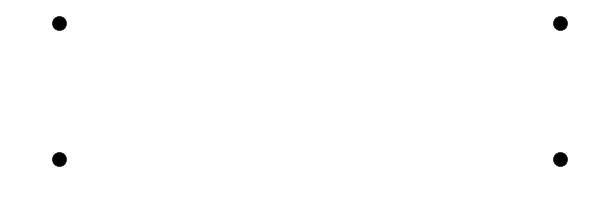

In [2]:
fig, ax = plt.subplots(figsize=(10,3))
colors = 'k'
#ax.scatter([1, 1], [0, 1], marker='x', s=200, c=['r', 'b'])
#colors = ['r', 'b', 'r', 'b']
ax.scatter([0, 0, 2, 2], [0, 1, 0, 1], s=200, c=colors)
ax.axis('off')
plt.show()

There are a couple common way to choose initial clusters. One is to choose randomly cluster centers from the initial points. Another is to randomly assign points to clusters and then find the centers of those.

Like many algorithms, it's easy to get caught in a local minimum. The usual way to avoid this is run the algorithm a number of times and find the best solution. `sklearn` does this automatically with the `n_init` parameter.

That helps, but can we choose better starting points?

**k-means++** is the same algorithm as k-means but with a specific initialization strategy, attempting to find initial points near the center of different clusters.

 * Choose one point for first center.
 * Repeat:
    
    * Calculate distance from each point to the nearest center $d_i$
    * Choose a point to be the next center, randomly, using a weighed probability $d_i^2$

Repeat until k centers have been chosen.

## What's the correct number of clusters?

So far we've talked about a way to find the "best" segmentation of a dataset into $K$ pieces, but you need to know $K$ before running the k-means algorithm.

Oftentimes, the choice of $K$ is driven by outside constraints

> We need to segment this data into 50 groups and create profiles for those groups so marketing can target customer segments.

In these situations the number $50$ is driven by a business concern.  We don't really believe our data consists of $50$ distinct subpopulations, but we want to give our coworkers something easy and definite to work with.

Other times, we have some suspicion that subpopulations actually exist in our data, and we want to use a data based approach to determine how many.

**Note:** Remember, **we don't have labels of the subpopulations**, or we would be using supervised learning! Stringent validation of whether we have found the correct clusters is **not possible** even if those clusters actually exist!

Our only option is to develop heuristics, and see if they do the right thing in cases we engineer where we **do** know the answer.

In [3]:
cluster_spec = [
    # (n_points, center, variance)
    (100, (-2, -3), 0.75),
    (75, (-5, -5), 0.75),
    (200, (4, 3), 1.5),
    (150, (1, -3), 0.5),
    (100, (-1, 0.15), 0.75)
]

x = make_gaussian_clusters(cluster_spec)

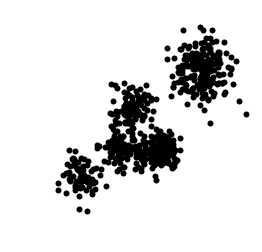

In [4]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.axis('off')
ax.axis('equal')
ax.scatter(x[:,0], x[:,1], linewidths=0, color='k')
_ = ax.set_xlim(xmin=-9, xmax=8)

How many clusters do you see?

Let's try fitting them with k-means.

In [5]:
km = KMeans(5)
labels = km.fit_predict(x)

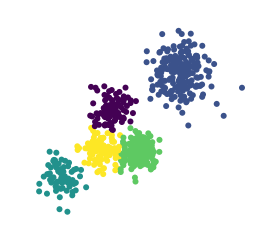

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.axis('off')
ax.axis('equal')
ax.scatter(x[:,0], x[:,1], c=labels, linewidths=0)
ax.set_ylim(ymin=-9, ymax=8)
plt.show()

These are basically the clusters we created the data from.  So, at least in this simple case, if we know $K$ beforehand, k-means will find it.

# Choosing K

Can we just use within-cluster sum of squares (WCSS) to choose k?


More clusters $\implies$ lower WCSS.

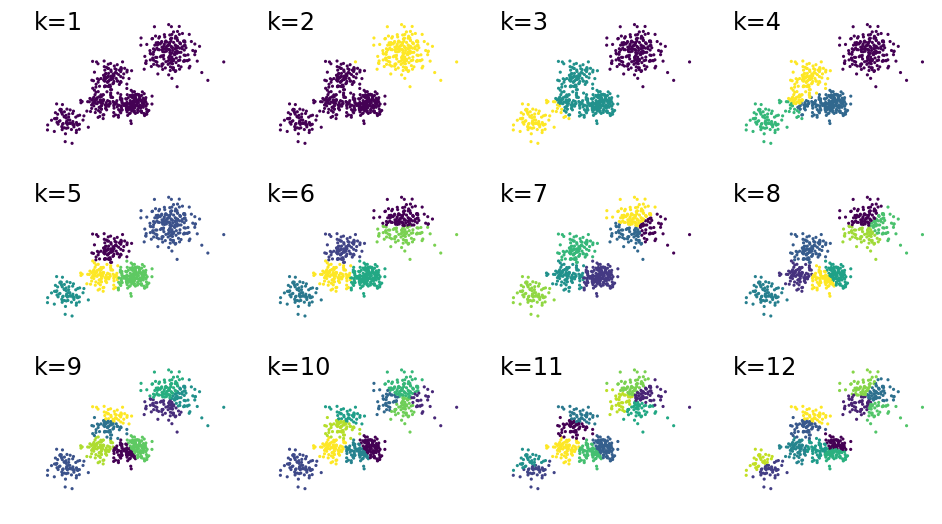

In [7]:
maxk = 13
wcss = np.zeros(maxk)
silhouette = np.zeros(maxk)

fig, axs = plt.subplots(3, 4, figsize=(16,9))

for k, ax in zip(range(1, maxk), axs.flatten()):
    km = KMeans(k)
    y = km.fit_predict(x)
    for c in range(0, k):
        for i1, i2 in itertools.combinations([ i for i in range(len(y)) if y[i] == c ], 2):
            wcss[k] += sum(x[i1] - x[i2])**2
    wcss[k] /= 2
    
    ax.axis('off')
    ax.scatter(x[:,0], x[:,1], c=y, linewidths=0, s=10)
    ax.set_ylim(ymin=-9, ymax=8)
    ax.text(-8, 8, f"k={k}",
            fontsize=24,
            horizontalalignment='left',
            verticalalignment='top')
    
    if k > 1:
        silhouette[k] = silhouette_score(x,y)

You can see that k-means happily segments the data into more and more clusters, even when they don't really exist.

The within cluster sum of squares marches steadily downwards the more and more clusters we ask for, so we can-not naievely use this to help us identify an "optimal" K.

Text(0,0.5,'within-cluster sum of squares')

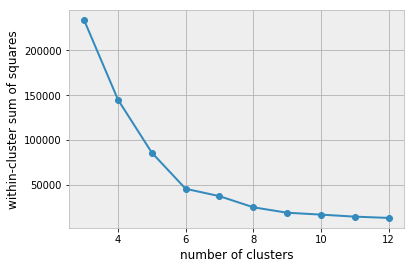

In [8]:
fig, ax = plt.subplots()
ax.plot(range(3,maxk), wcss[3:maxk], 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("within-cluster sum of squares")

## The Elbow Method

The Elbow method is a heuristic for choosing K.  The idea here is that if our data **really** contains five distinct subpopulations than:

  - Going from no clusters to two clusters should **greatly** decrease the WCSS.
  - Going from two clusters to three clusters should **greatly** decrease the WCSS.
  - Going from three clusters to four clusters should **greatly** decrease the WCSS.
  - Going from four clusters to five clusters should **greatly** decrease the WCSS.
  - Going from four clusters to five clusters should **not greatly** decrease the WCSS!
  
In the first four cases, we have grouped what **should** be distinct clusters into the same class, and increasing K should split that false cluster into two "true" clusters, so we expect the WCSS to decrease significantly to reflect that.

On the other hand, when we are **no longer** splitting a false cluster, the WCSS should not have suck a noticeable decrease.

To use this heuristic, we simply plot the within-cluster sum of squares and try to see what looks like an elbow.  An "elbow" being a point of transition from large decreases to small decreases.

Where do **you** see an elbow?

Text(0,0.5,'within-cluster sum of squares')

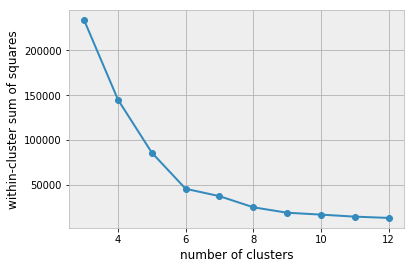

In [9]:
fig, ax = plt.subplots()
ax.plot(range(3,maxk), wcss[3:maxk], 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("within-cluster sum of squares")

I see it here:

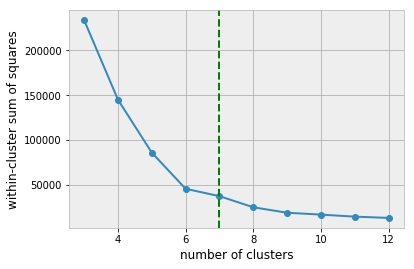

In [10]:
fig, ax = plt.subplots()
ax.plot(range(3,maxk), wcss[3:maxk], 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("within-cluster sum of squares")
ax.axvline(x=7, color="green", linestyle="--")

So we didn't get the correct answer.  Looking at the actual clusters, it looks like in the last two increases for K we were splitting a large cluster up into false subclusters.  Since this cluster was naturally larger than the others, this fooled our heuristic.

**The elbow method is just a heuristic, it's easy to find situations that defeat it!**

# Silhouette Scores

The **Silhouette score** of a point within a cluster is a measurement of how **confidently** the point is assigned to each cluster.

For each point $x_i$:

 - $a(i)$ average dissimilarity/distance of $x_i$ with/to points in the same cluster
 - $b(i)$ average dissimilarity/distance of $x_i$ with/to points in the nearest cluster
    - "nearest" means cluster with the smallest $b(i)$

$$\text{silhouette}(i) = \frac{b(i) - a(i)}{max(a(i), b(i))} $$

What's the range of silhouette scores?

The original paper gave the following heuristic interpretation of silhouette scores:

```
Possible silhouette scores:
 * near 1: very small tight cluster.
 * 0: at the edge of two clusters; could be in either.
 * < 0: oops.
```

# Silhouette Graphs

A silhouette graph is a representation of the silhouette score of ever data point, grouped first by cluster and then in decreasing value.

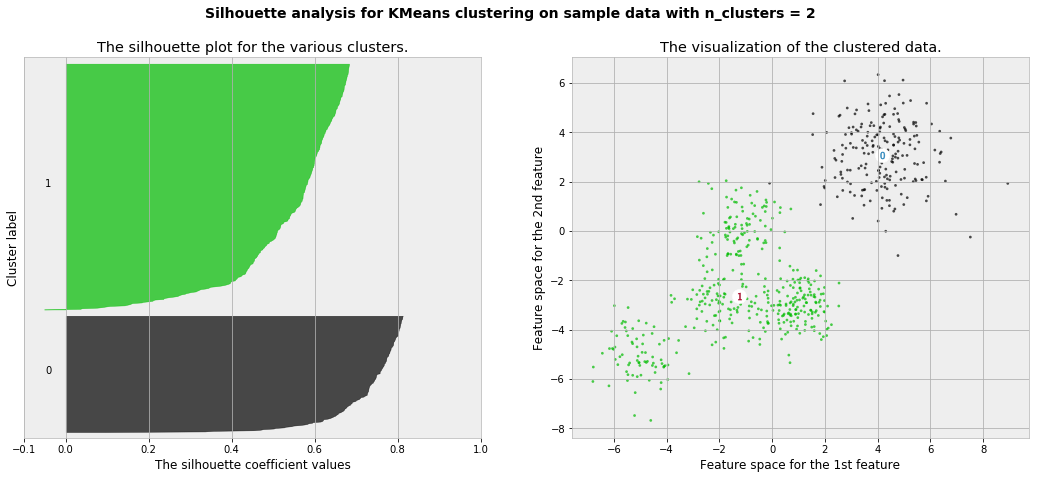

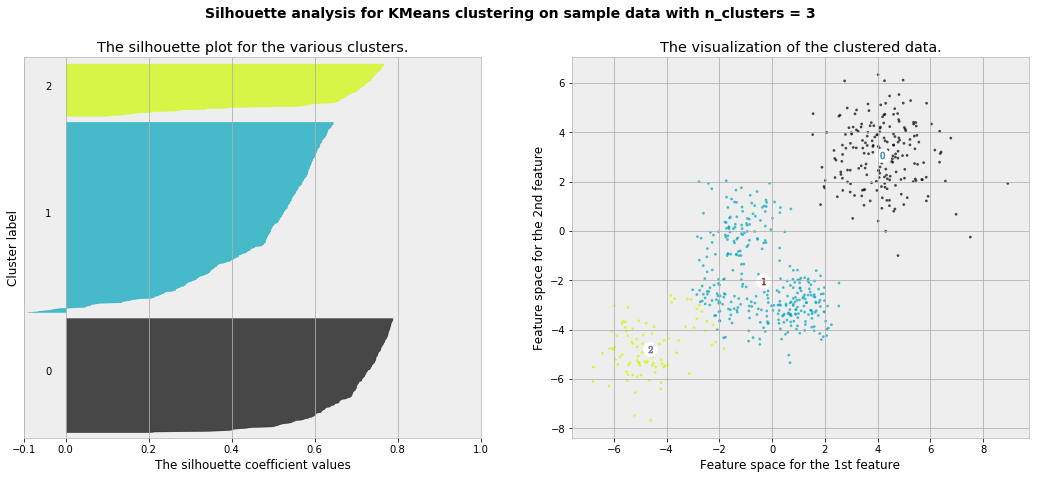

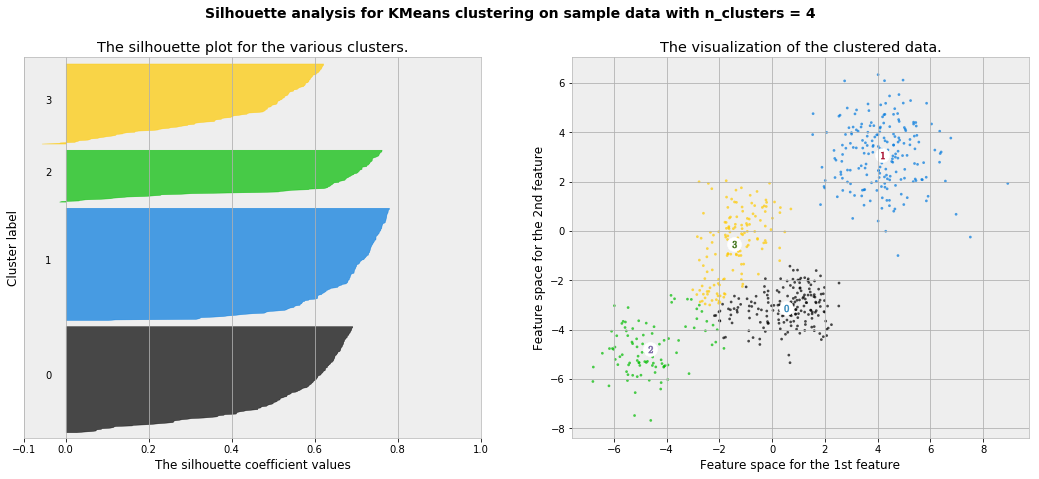

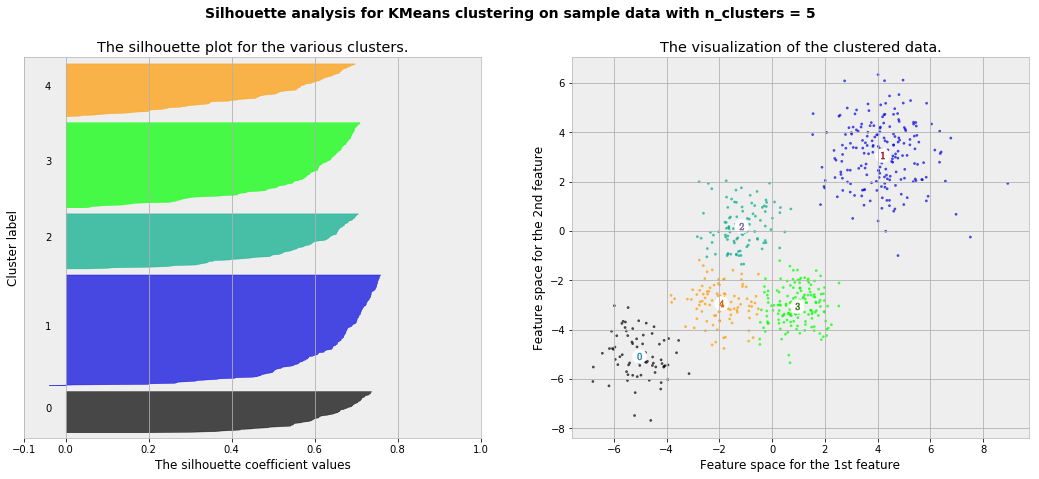

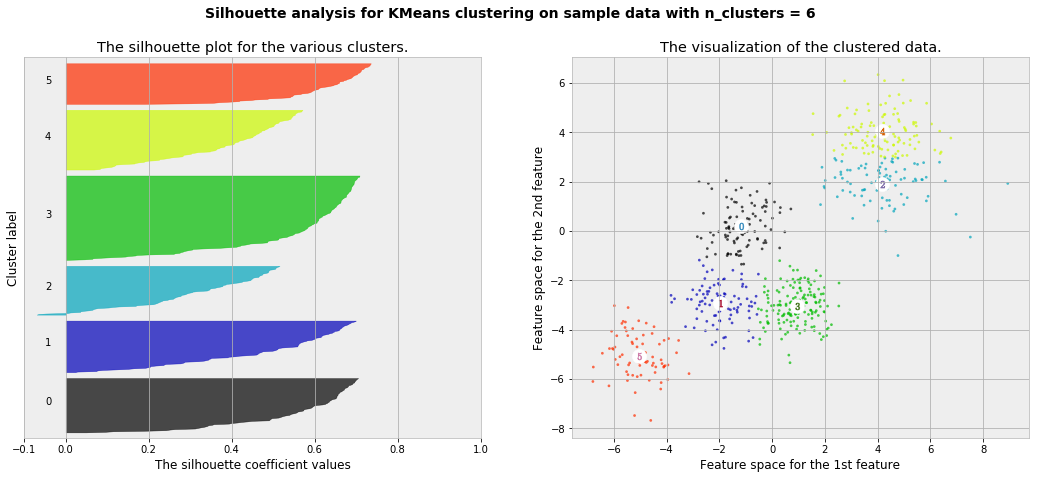

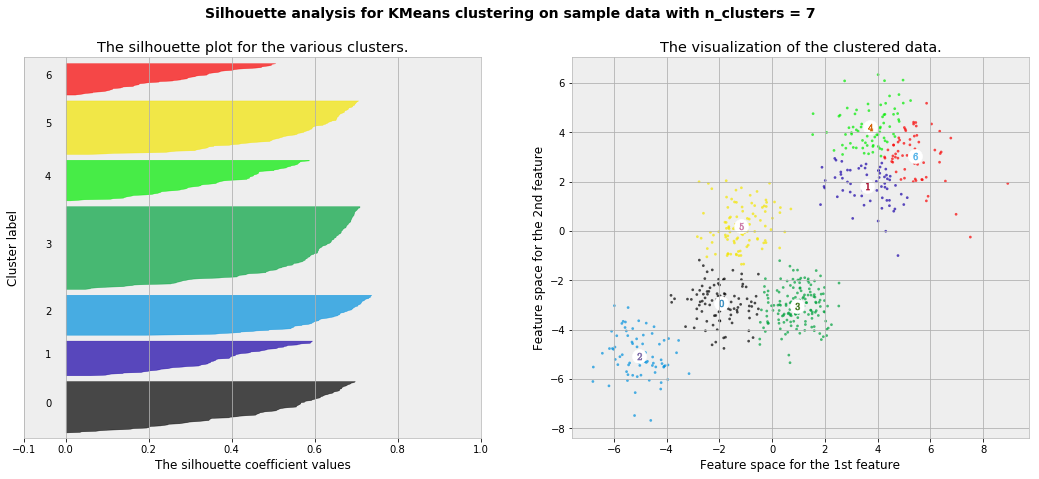

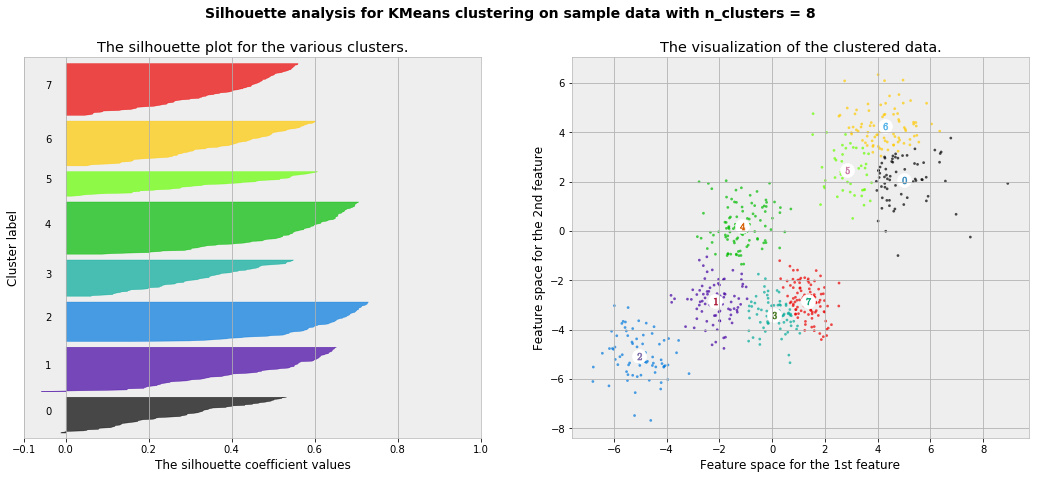

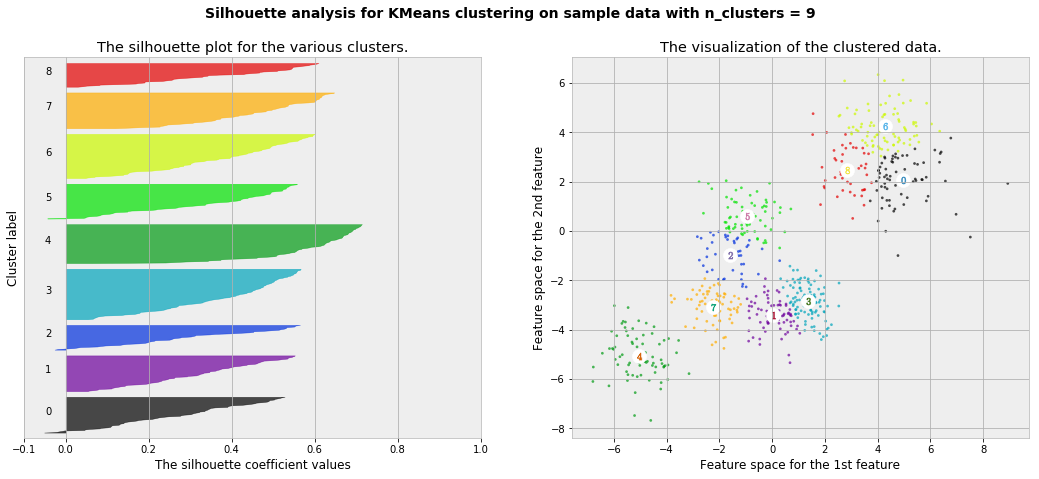

In [11]:
range_n_clusters = range(2,10)
silhouette_scores = np.empty(shape=8)

for idx, n_clusters in enumerate(range_n_clusters):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    score = make_silhouette_plot(axs, x, n_clusters=n_clusters)
    silhouette_scores[idx] = score

# Choosing K -- Silhouette Score

The silhouette score of a clustering is the average of silhouette score of all points.

Text(0,0.5,'silhouette score')

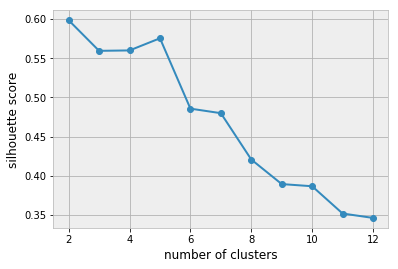

In [12]:
fig, ax = plt.subplots()
ax.plot(range(2,maxk), silhouette[2:maxk], 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("silhouette score")

The higher the average silhouette score, the tighter and more separated the clusters.

# Hierarchical Clustering

K-means progressed by grouping the dataset into a fixed (pre-specified) number of classes. With hierarchical clustering we group data points as leaves on a tree, clustering them into larger and larger groups.

**Discussion:** How would we group these five datapoints.

![](images/letters-ungrouped.png)

The basic idea of hierarchical clustering is to start at the most granular level possible (each datapoint is in its own cluster).  Then we start to merge together clusters one at a time.  Eventually everything is merged, and we end up with a single cluster containing all of the data.

### Algorithm

 * Assign each point to its own cluster
 * Repeat:

   * Compute distances between clusters
   * Merge closest clusters

Until all the datapoints are merged into one large cluster.

<table><tr><td><img src='images/letters-grouped.png'></td><td><img src='images/letters-dendrogram.png'></td></tr></table>

**Discussion**: How do we define similarity/dissimilarity between clusters?

## Linkage

It's easy to talk about the distance (or dissimilarity) between two points, but we need a distance/similarity measure between **clusters**.

There are a few different measures used:

  - **Ward:** Minimizes the within cluster variance.
  - **Complete:** Distance between clusters is maximum pairwise dissimilarity between points in clusters.
  - **Average:** Distance between clusters is average of pairwise dissimilarity between points in clusters.
  
There's a fourth common one, but it is not currently supported in sklearn.

  - **Single:** Minimum pairwise dissimilarity between points in clusters.

In [13]:
linkages = ['ward', 'complete', 'average']
hierarchical_clustering_algorithms = {
    (linkage, n): AgglomerativeClustering(
        n_clusters=n, linkage=linkage)
    for linkage, n in itertools.product(linkages, [2, 4, 5])
}

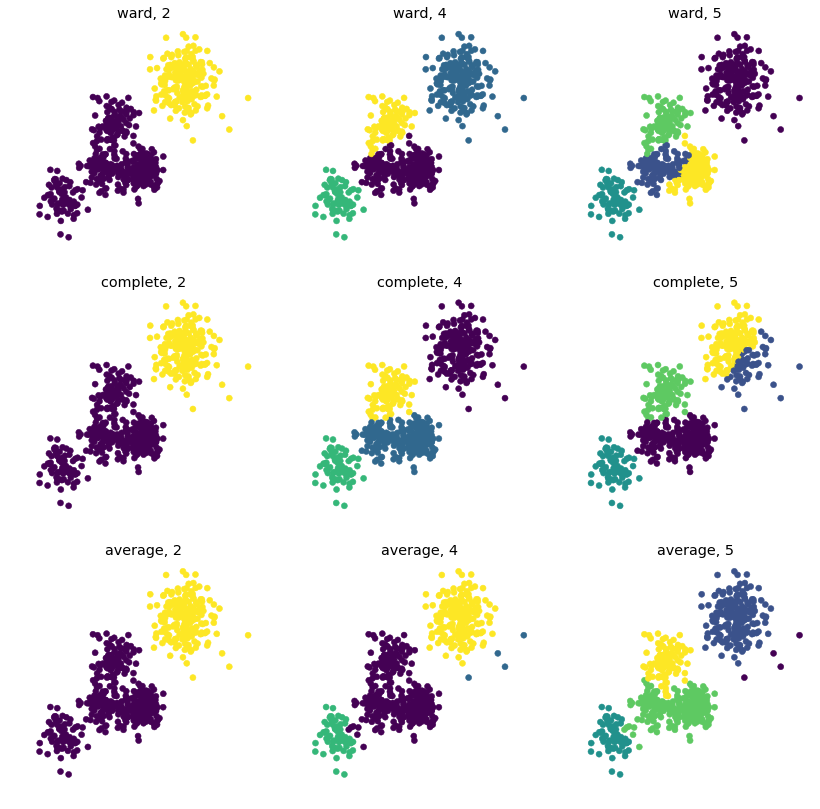

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(14, 14))

for (linkage, n), ax in zip(hierarchical_clustering_algorithms, axs.flatten()):
    clusterer = hierarchical_clustering_algorithms[(linkage, n)]
    clusterer.fit(x)
    labels = clusterer.labels_
    ax.axis('off')
    ax.scatter(x[:, 0], x[:, 1], c=labels)
    ax.set_title(f"{linkage}, {n}")

# Limitations of K-means (and Other Methods)

K-means has many limitations, it's important to think through them.

## Unequal Cluster Sizes

In [15]:
g = make_gaussian_clusters([
    (5000, (2, 2), (1, 1)),
    (200, (-1, -1), (1, 1))
])

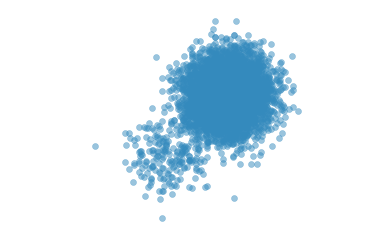

In [16]:
fig, ax = plt.subplots()
ax.scatter(g[:, 0], g[:, 1], alpha=0.5)
ax.set_aspect('equal', 'datalim')
_ = ax.axis('off')

In [17]:
km = KMeans(2)
km.fit(g)
labels = km.predict(g)

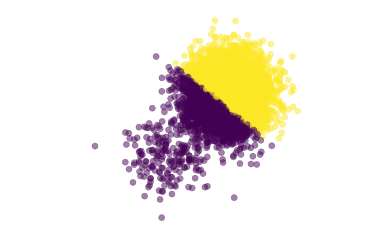

In [18]:
fig, ax = plt.subplots()
ax.scatter(g[:, 0], g[:, 1], c=labels, alpha=0.5)
ax.set_aspect('equal', 'datalim')
_ = ax.axis('off')

## Non Spherical Clusters

In [19]:
r = np.concatenate([scs.norm(8,1).rvs(250),
                    scs.norm(2,1).rvs(50)])
theta = scs.uniform(0, 6.28).rvs(300)
x_ring = r * np.cos(theta)
y_ring = r * np.sin(theta)

(-11.067036058954635,
 11.716879468465564,
 -10.721000276514127,
 11.635639279919436)

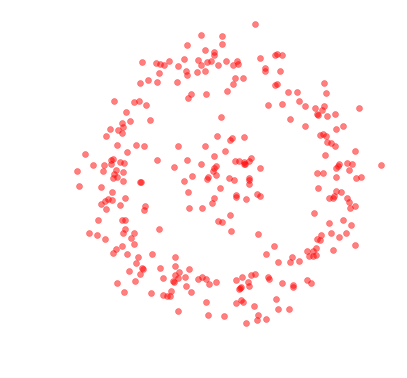

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')
ax.scatter(x_ring, y_ring, color="r", alpha=0.5)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.axis('off')

**Discussion:** What will k-means do here?

In [21]:
X_ring = np.stack((x_ring, y_ring), axis=1)
km = KMeans(2).fit(X_ring)
labels = km.predict(X_ring)

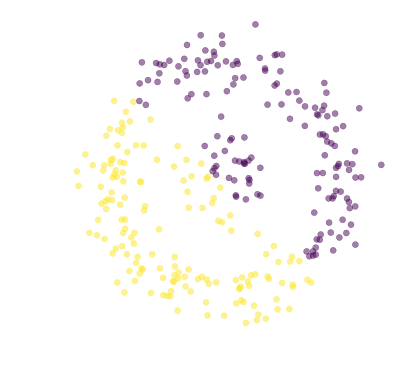

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
ax.axis('equal')
ax.scatter(x_ring, y_ring, c=labels, alpha=0.5)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
_ = ax.axis('off')

It did the best it could.

If we change our point of view, we can make it work!

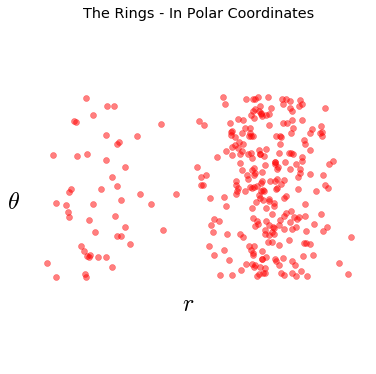

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('equal')
ax.scatter(r, theta, color="r", alpha=0.5)

ax.text(5, -0.5, r"$r$",
        fontsize=24,
        horizontalalignment='left',
        verticalalignment='top')
ax.text(-1, 3, r"$\theta$",
        fontsize=24,
        horizontalalignment='left',
        verticalalignment='top')

ax.set_title("The Rings - In Polar Coordinates")
_ = ax.axis('off')

In [24]:
polar_ring = np.stack((r, theta), axis=1)
km = KMeans(2).fit(polar_ring)
labels = km.predict(polar_ring)

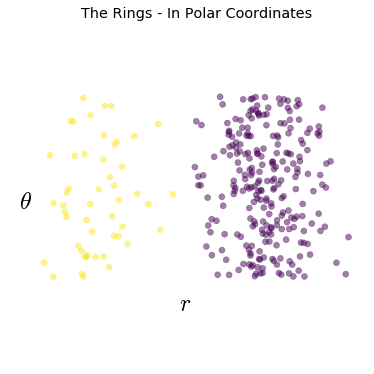

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('equal')
ax.scatter(r, theta, c=labels, alpha=0.5)

ax.text(5, -0.5, r"$r$",
        fontsize=24,
        horizontalalignment='left',
        verticalalignment='top')
ax.text(-0.5, 3, r"$\theta$",
        fontsize=24,
        horizontalalignment='left',
        verticalalignment='top')

ax.set_title("The Rings - In Polar Coordinates")
_ = ax.axis('off')

It's important to use measurements that most easily express the structure of the data!

## The Curse of Dimensionality

Most (all?) of our intuition about geometric concepts is built upon our experiences in low dimensions.  Oftentimes, this intuition fails **catastrophically** in high dimensional spaces.

The Curse of Dimensionality is a way of saying that in high-dimensional space, things behave in ways that are quite different than our intuition. In particular, models based largely on using **distances between datapoints** will encounter serious difficulties.

Random variation in extra dimensions can hide significant differences between clusters. This can become a serious problem with a large number of dimensions, as no point is really close to any other point and distances alone because less meaningful.

Consider two clusters plotted in increasing numbers of dimensions. How much do they overlap?

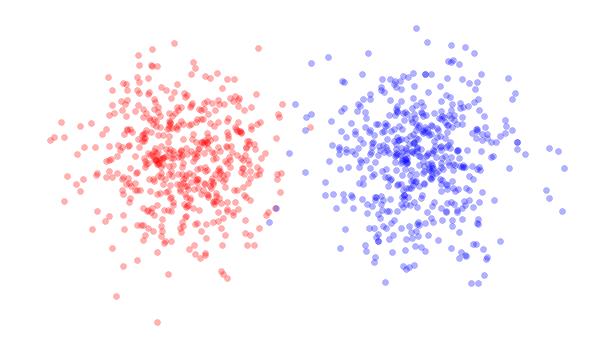

In [26]:
count = 500
sep = 5.

x = np.zeros((2, 2*count))

# First dimension seperates the clusters.
x[0,:] = np.concatenate(
    (scs.norm(-sep / 2, 1).rvs(count), 
    (scs.norm(sep / 2, 1).rvs(count))))
# All other dimensions are random noise.
x[1, :] = scs.norm(0, 1).rvs(2*count)

fig, ax = plt.subplots(figsize=(10,6))
ax.axis('equal')
ax.scatter(x[0, :count], x[1, :count], c='r', alpha=0.3)
ax.scatter(x[0, count:], x[1, count:], c='b', alpha=0.3)
_ = ax.axis('off')

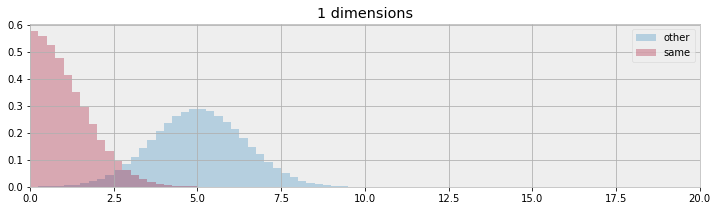

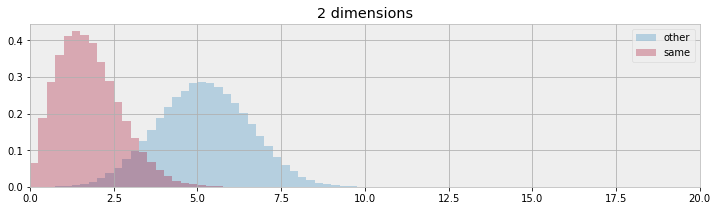

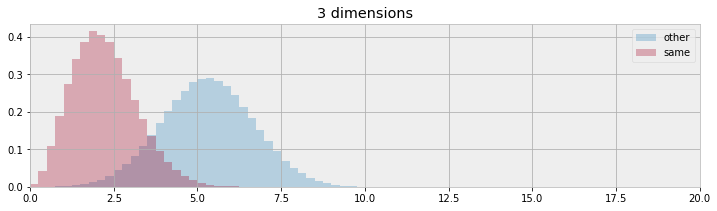

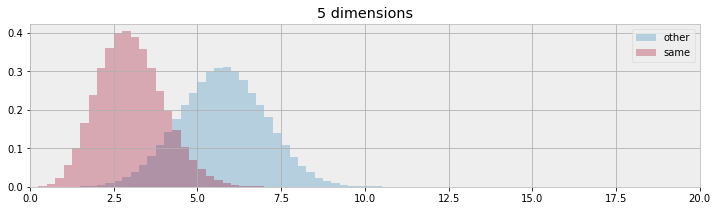

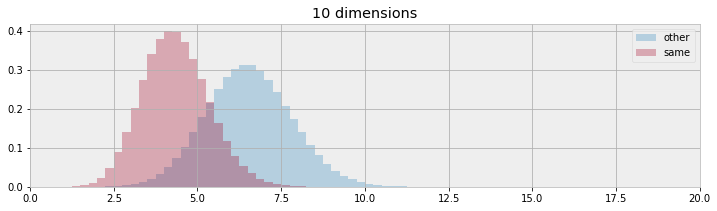

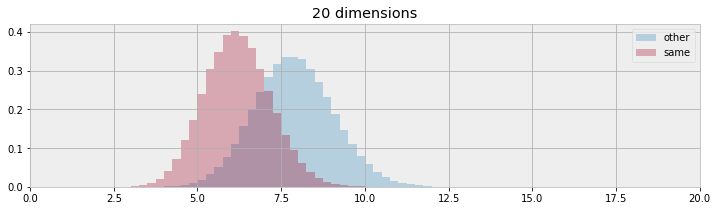

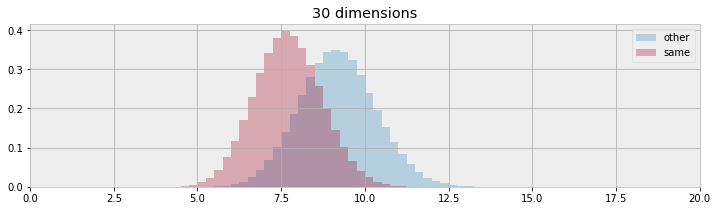

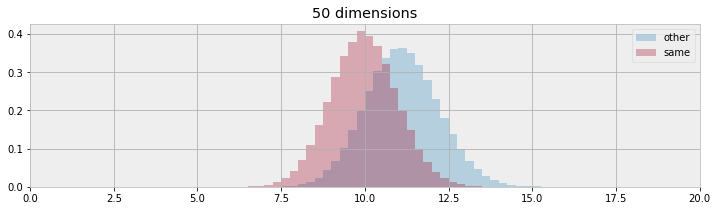

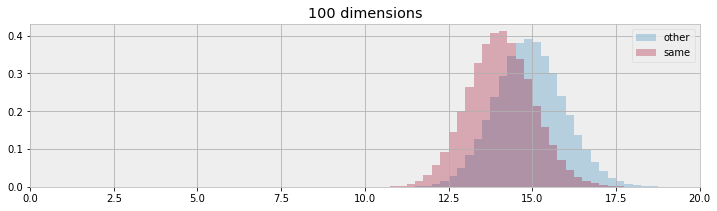

In [27]:
for dims in [1, 2, 3, 5, 10, 20, 30, 50, 100]:
    x = np.zeros((dims, 2*count))
    # First dimension seperates the clusters.
    x[0,:] = np.concatenate(
        (scs.norm(-sep/2., 1).rvs(count), 
        (scs.norm(sep/2., 1).rvs(count))))
    # All other dimensions are random noise.
    for d in range(1, dims):
        x[d, :] = scs.norm(0, 1).rvs(2*count)

    clusterlabels = ["cluster 1"] * count + ["cluster 2"] * count 
    
    y = []
    dist = []
    for i in range(2*count):
        for j in range(i+1, 2*count):
            d = np.sqrt(sum((x[:,i] - x[:, j])**2))
            dist.append(d)
            y.append("same" if i // count == j // count else "other")
    multihist(np.array(dist), np.array(y), binsize=0.25, figsize=(12,3),
                   xmin=0, xmax=20, title="{0} dimensions".format(dims))

    plt.show()

As the number of dimensions get large, the **every** point is far from its neighbors, even those in the same clusters. The differences between that and neighboring clusters is washed out.

We will have more to say about the curse of dimensionality tomorrow.

## Similarity and Dissimilarity

Recall that K-means clustering is essentially a (greedy) minimization procedure that attempts to assign points to clusters to minimize the within cluster sum of squares metric:

$$W(C) = \sum_{\text{clusters C}} \left( \sum_{i,j \text{ in the same cluster C}} || x_i - x_j ||^2 \right)$$

We can think of this as minimizing the **dissimilarity** of points assigned to the same cluster:

$$ \text{dissimilarity}(x_i, x_j) = || x_i - x_j ||^2 $$

The choice of Euclidean distance as a dissimilarity metric is a hidden assumption within the K-means algorithm.

**Discussion:** What assumptions are hidden within this choice of metric?

I'll sign off with this advice for [The Elements of Statistical Learning]()

> Although simple generic prescriptions for choosing the individual attribute dissimilarities [...] can be comforting, there is no substitute for careful thought in the context of each individual problem.  **Specifying an appropriate dissimilarity measure is far more important in obtaining success with clustering than the choice of clustering algorithm**

The point here is important and generic.  Clustering works by grouping the data points based on similarity (or segregating them by dissimilarity, which amounts to the same thing).  The measure of similarity/dissimilarity you use should be **relevant to the problem you are trying to solve**.  Otherwise, what are you really doing?